In [1]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr

In [3]:
df_GPU=pd.read_csv('FACT_GPU_PRICE.csv')
df_GPU['Date']=pd.to_datetime(df_GPU['TimeId'].astype(str), format="%Y%m%d")
df_GPU.set_index('Date', inplace=True)
#df_GPU=df_GPU.reindex(pd.date_range('2013-03-22', '2018-03-16'))
#df_GPU.index.freq='D'
#df_GPU.fillna(method='ffill', inplace=True)
df_GPU

,ProdId,TimeId,RegionId,MerchantId,Price_USD,Price_Original
Date,,,,,,
2014-09-17,1,20140917,4,32,601.738413,463.900
2014-09-18,1,20140918,4,32,551.885276,425.870
2014-09-19,1,20140919,4,32,548.098896,424.530
2014-09-20,1,20140920,4,32,545.093860,424.530
2014-09-21,1,20140921,4,32,544.674245,424.530
...,...,...,...,...,...,...
2018-03-12,2054,20180312,4,32,261.254103,212.090
2018-03-13,2054,20180313,4,32,263.058996,212.090
2018-03-14,2054,20180314,4,32,261.517908,211.415


In [4]:
df=df_GPU[df_GPU['ProdId']==1047]['Price_USD'].groupby('Date').mean()
#df_NVidia
df=df.iloc[3:]
df.reindex(pd.date_range('2016-06-10', '2018-03-16',freq='D'))

df=df.asfreq('D')
df.fillna(method='ffill', inplace=True)
df=pd.DataFrame(df)

<AxesSubplot:xlabel='Date'>

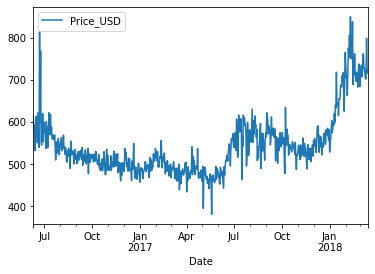

In [5]:
df.plot()

In [6]:
train=df.iloc[:-30]
test=df.iloc[-30:]

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler=MinMaxScaler()


In [9]:
scaler.fit(train)

MinMaxScaler()

In [10]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [11]:
n_input=7
n_features=1
generator=TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [12]:
len(generator)

608

In [13]:
generator[0]

(array([[[0.49494322],
         [0.4219714 ],
         [0.4516379 ],
         [0.32268322],
         [0.36482185],
         [0.4943777 ],
         [0.48615631]]]),
 array([[0.41235751]]))

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [15]:
model=Sequential()

In [16]:
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))

In [17]:
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit_generator(generator, epochs=50)

<ipython-input-19-a3356272c98c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=50)


Epoch 1/50
608/608 [==============================] - 4s 4ms/step - loss: 0.0071
Epoch 2/50
608/608 [==============================] - 3s 5ms/step - loss: 0.0050
Epoch 3/50
608/608 [==============================] - 4s 6ms/step - loss: 0.0042
Epoch 4/50
608/608 [==============================] - 3s 4ms/step - loss: 0.0045
Epoch 5/50
608/608 [==============================] - 3s 5ms/step - loss: 0.0043
Epoch 6/50
608/608 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 7/50
608/608 [==============================] - 2s 3ms/step - loss: 0.0043
Epoch 8/50
608/608 [==============================] - 2s 3ms/step - loss: 0.0042
Epoch 9/50
608/608 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 10/50
608/608 [==============================] - 3s 4ms/step - loss: 0.0043
Epoch 11/50
608/608 [==============================] - 3s 4ms/step - loss: 0.0040
Epoch 12/50
608/608 [==============================] - 3s 5ms/step - loss: 0.0040
Epoch 13/50
608/608 [====

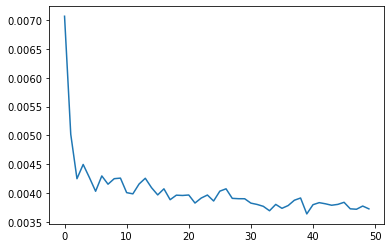

In [20]:
los_per_epoch=model.history.history['loss']
plt.plot(range(len(los_per_epoch)),los_per_epoch)

In [21]:
first_eval_batch=scaled_train[-7:]
first_eval_batch

array([[0.90468563],
       [0.82007643],
       [1.        ],
       [0.78810218],
       [0.81572799],
       [0.78683852],
       [0.97492114]])

In [22]:
first_eval_batch=first_eval_batch.reshape((1, n_input,n_features))

In [23]:
first_eval_batch

array([[[0.90468563],
        [0.82007643],
        [1.        ],
        [0.78810218],
        [0.81572799],
        [0.78683852],
        [0.97492114]]])

In [24]:
model.predict(first_eval_batch)

array([[0.87627494]], dtype=float32)

In [25]:
test_predictions=[]

In [26]:
first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1, n_input, n_features))

In [27]:
for i in range(len(test)):
  current_pred=model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch=np.append(current_batch[:, 1:, :],[[current_pred]], axis=1)

In [28]:
len(test_predictions)

30

In [29]:
true_predictions=scaler.inverse_transform(test_predictions)

In [30]:
test

,Price_USD
Date,
2018-02-15,688.793751
2018-02-16,752.847622
2018-02-17,711.587232
2018-02-18,762.001425
2018-02-19,717.255592
2018-02-20,705.445658
2018-02-21,696.508054
2018-02-22,717.925865
2018-02-23,710.544781


In [31]:
test['predictions'] = true_predictions

<ipython-input-31-fa6c3af7c69f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

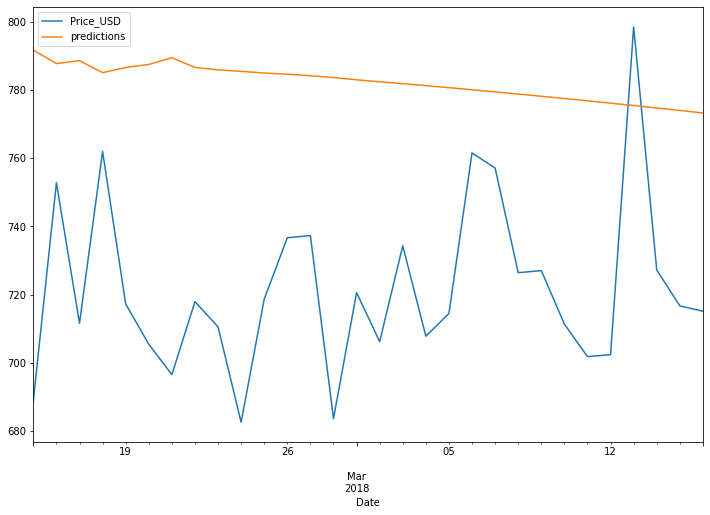

In [32]:
test.plot(figsize=(12,8))

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))


In [34]:
mean_absolute_percentage_error(test['Price_USD'], test['predictions'])

0.08717751491947087